In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import joblib
import ipaddress

# **Load datasets**

In [105]:
def load_data():

    fraud_data = pd.read_csv('/content/drive/MyDrive/Data/Fraud_Data.csv')
    ip_address = pd.read_csv('/content/drive/MyDrive/Data/IpAddress_to_Country.csv')
    creditcard_data = pd.read_csv('/content/drive/MyDrive/Data/creditcard.csv.zip')
    return fraud_data, ip_address, creditcard_data

fraud_data, ip_address, creditcard_data = load_data()

In [106]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


# **Data overview**

In [107]:
def data_overview(df):
    num_rows = df.shape[0]
    num_columns = df.shape[1]
    data_types = df.dtypes

    print(f"Number of rows:{num_rows}")
    print(f"Number of columns:{num_columns}")
    print(f"Data types of each column:\n{data_types}")

data_overview(fraud_data)

Number of rows:151112
Number of columns:11
Data types of each column:
user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
dtype: object


# **Handling missing values**

In [108]:
def check_missing(df):
    missing = df.isnull().sum()

    return missing

check_missing(fraud_data)

,0
user_id,0
signup_time,0
purchase_time,0
purchase_value,0
device_id,0
source,0
browser,0
sex,0
age,0
ip_address,0


# **Data cleaning**

In [109]:
def data_cleaning(df):
    # Remove duplicates
    df.drop_duplicates(inplace=True)

    print("Duplicates are removed from fraud data!")

    # convert timestamps

    df['signup_time'] = pd.to_datetime(df['signup_time'])
    df['purchase_time'] = pd.to_datetime(df['purchase_time'])

    print("Timestamps are converted!")
data_cleaning(fraud_data)

Duplicates are removed from fraud data!
Timestamps are converted!


In [110]:
def summarize_dataset(df, numerical_columns):
    """
    Calculates summary statistics for numerical columns in a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to summarize.
        numerical_columns (list or str): A list of numerical column names or a single column name.

    Returns:
        pd.DataFrame: A DataFrame containing the summary statistics for the specified columns.
    """
    # If numerical_columns is a string (single column name), convert it to a list
    if isinstance(numerical_columns, str):
        numerical_columns = [numerical_columns]

    # Initialize a list to hold summary statistics for each column
    summary_list = []

    for col in numerical_columns:
        summary_stats = {
            'Mean': df[col].mean(),
            'Median': df[col].median(),
            'Mode': df[col].mode().iloc[0],  # Taking the first mode in case of multiple modes
            'Standard Deviation': df[col].std(),
            'Variance': df[col].var(),
            'Range': df[col].max() - df[col].min(),
            'IQR': df[col].quantile(0.75) - df[col].quantile(0.25),
            'Skewness': df[col].skew(),
            'Kurtosis': df[col].kurtosis()
        }

        # Append the summary statistics for the current column to the list
        summary_list.append(summary_stats)

    # Convert summary stats list to DataFrame with appropriate index
    summary_df = pd.DataFrame(summary_list, index=numerical_columns)

    return summary_df

# Specify the numerical column name as a string
numerical_columns = 'purchase_value'
summarize_dataset(fraud_data, numerical_columns)

,Mean,Median,Mode,Standard Deviation,Variance,Range,IQR,Skewness,Kurtosis
purchase_value,36.935372,35.0,28,18.322762,335.723613,145,27.0,0.670485,0.138292


# **Univariate analysis**

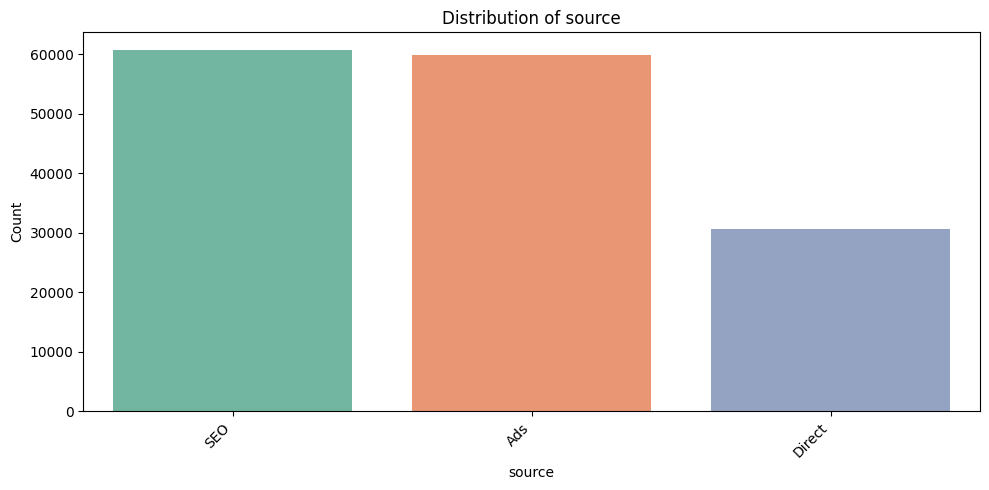

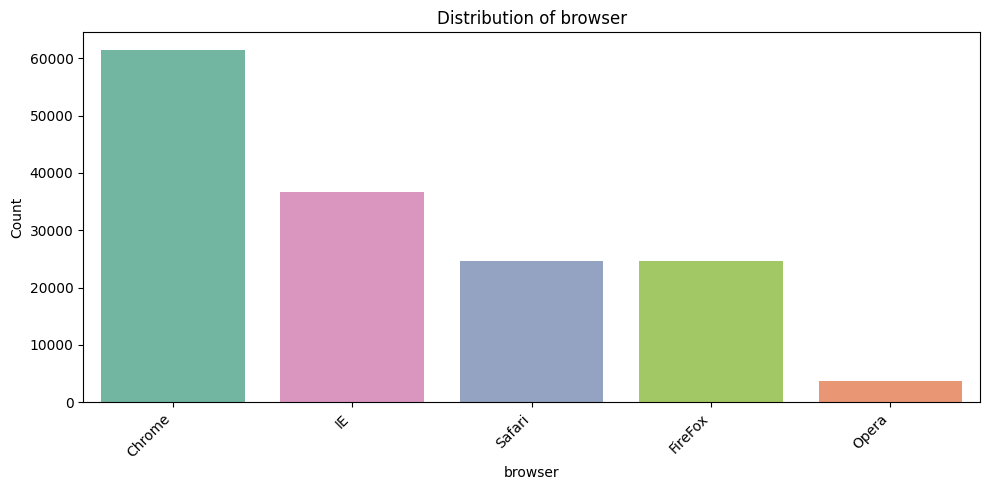

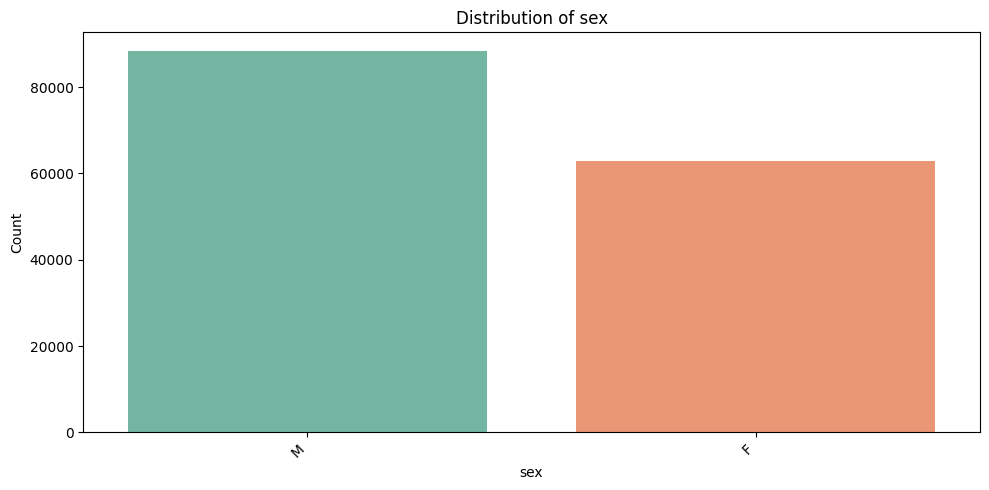

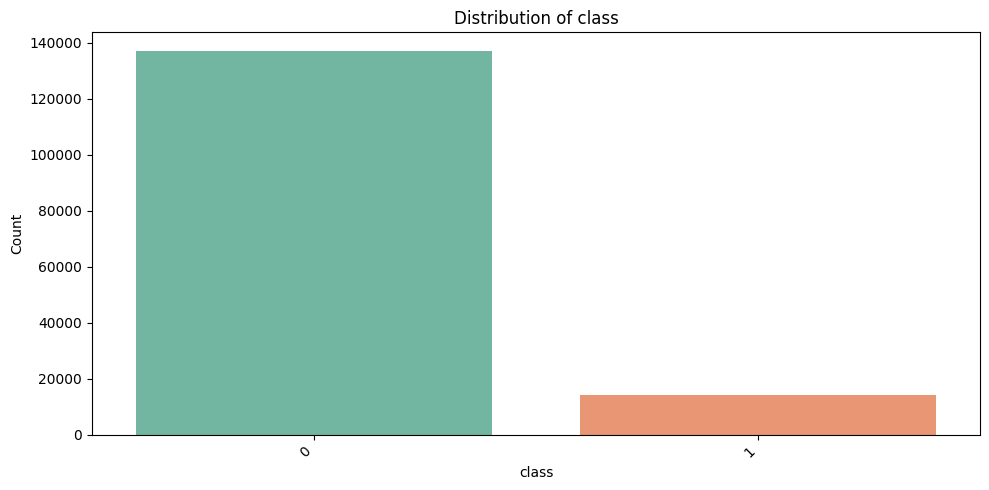

In [111]:
def plot_univariate(df):
            # Select categorical columns only
            categorical_columns=['source','browser','sex','class']

            # Create bar plots for each categorical feature
            for col in categorical_columns:
                plt.figure(figsize=(10, 5))

                # Plot a bar chart for the frequency of each category
                sns.countplot(x=df[col], order=df[col].value_counts().index, hue=df[col], palette="Set2", legend=False)

                # sns.countplot(x=df[col], order=df[col].value_counts().index, palette="Set2")

                plt.title(f'Distribution of {col}')
                plt.xticks(rotation=45, ha='right')
                plt.ylabel('Count')
                plt.tight_layout()
                plt.show()
plot_univariate(fraud_data)

# **Bivariate analysis**

In [112]:
def cramers_v(df,var1, var2):
    # Create a contingency table
    contingency_table = pd.crosstab(df[var1], df[var2])

    # Perform Chi-Square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Calculate Cramér's V
    n = contingency_table.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

    # Visualize the heatmap of the contingency table
    plt.figure(figsize=(8, 6))
    sns.heatmap(contingency_table, annot=True, fmt="d", cmap='Blues')
    plt.title(f'Contingency Table for {var1} and {var2}')
    plt.xlabel(var2)
    plt.ylabel(var1)
    plt.show()


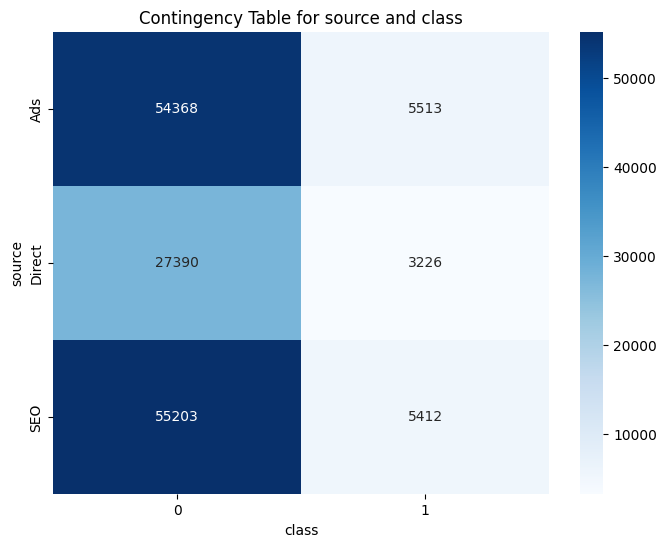

In [113]:
# 'source','browser','sex','class'
cramers_v(fraud_data,'source','class')

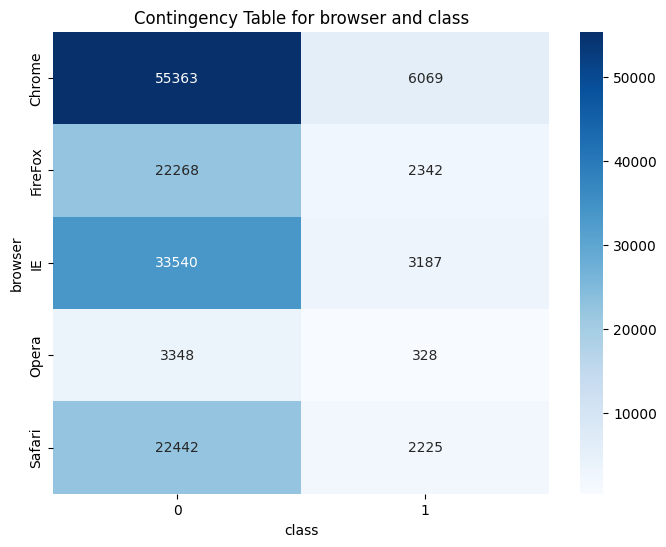

In [114]:
cramers_v(fraud_data,'browser','class')

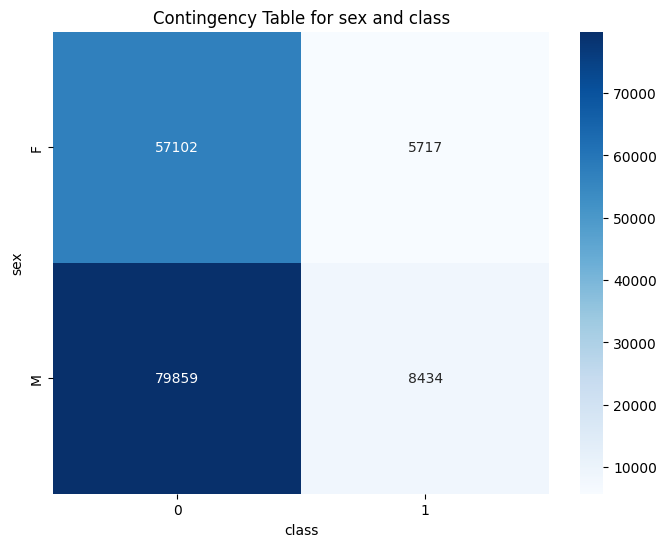

In [115]:
cramers_v(fraud_data,'sex','class')

# **Merge fraud data with ip address**

In [116]:
def merge_fraud_with_ip(fraud_df, ip_df):
            # Function to convert IP address to integer
            def ip_to_int(ip):
                ip=int(ip)
                try:
                    return int(ipaddress.ip_address(ip))
                except ValueError:
                    return None  # Handle invalid IPs by returning None

            # Convert 'ip_address' in fraud_df to integer format
            fraud_df['ip_address'] = fraud_df['ip_address'].apply(ip_to_int)

            # Convert 'lower_bound_ip_address' and 'upper_bound_ip_address' in ip_df to integer format
            ip_df['lower_bound_ip_address'] = ip_df['lower_bound_ip_address'].apply(ip_to_int)
            ip_df['upper_bound_ip_address'] = ip_df['upper_bound_ip_address'].apply(ip_to_int)

            # Function to find the country for a given IP address
            def find_country(ip_address):
                # Filter the rows in ip_df where the IP falls between lower and upper bounds
                matching_row = ip_df[(ip_df['lower_bound_ip_address'] <= ip_address) & (ip_df['upper_bound_ip_address'] >= ip_address)]
                if not matching_row.empty:
                    return matching_row.iloc[0]['country']  # Return the country of the first match
                return None  # Return None if no match is found
            # Create a new column 'country' by applying the find_country function to each row in fraud_df
            fraud_df['country'] = fraud_df['ip_address'].apply(find_country)

            return fraud_df


In [117]:
merged_df = merge_fraud_with_ip(fraud_data,ip_address)
merged_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443,0,None
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0,United States


In [118]:
def drop_null_country(df):
          # Drop rows where 'country' column has null values
          df_cleaned = df.dropna(subset=['country'])

          return df_cleaned

In [119]:
merged_df = drop_null_country(merged_df)
merged_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820,1,United States
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0,United States
5,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2809315199,0,Canada


# **Feature Engineering**

Transaction frequency and velocity for Fraud_Data.csv

Time-Based features for Fraud_Data.csv

In [120]:
def feature_engineering(df):
    # Transaction frequency (number of transactions by user_id)
    df['transaction_count'] = df.groupby('user_id')['user_id'].transform('count')

    # Time-based features
    df['purchase_time'] = pd.to_datetime(df['purchase_time'])
    df['hour_of_day'] = df['purchase_time'].dt.hour
    df['day_of_week'] = df['purchase_time'].dt.weekday

    return df

In [121]:
merged_df = feature_engineering(merged_df)
merged_df.head()

<ipython-input-120-c0370f9ab209>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transaction_count'] = df.groupby('user_id')['user_id'].transform('count')
<ipython-input-120-c0370f9ab209>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['purchase_time'] = pd.to_datetime(df['purchase_time'])
<ipython-input-120-c0370f9ab209>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,transaction_count,hour_of_day,day_of_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368,0,Japan,1,2,5
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387,0,United States,1,1,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820,1,United States,1,18,3
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0,United States,1,18,2
5,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2809315199,0,Canada,1,8,3


# **Normalization and Scaling**

In [122]:
def normalize_scale_features(df):
            scaler = StandardScaler()

            df[['purchase_value', 'transaction_count']] = scaler.fit_transform(df[['purchase_value', 'transaction_count']])
            # Save the fitted scaler for future use
            joblib.dump(scaler, '/content/drive/MyDrive/fraud detection/models/scaler.joblib')

            return df
def normalize_scale_creditcard_data(df):
    scaler = StandardScaler()

    df[['Amount','Time']] = scaler.fit_transform(df[['Amount','Time']])

    return df

In [123]:
merged_df = normalize_scale_features(merged_df)
creditcard_data = normalize_scale_creditcard_data(creditcard_data)

<ipython-input-122-a092916962ad>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['purchase_value', 'transaction_count']] = scaler.fit_transform(df[['purchase_value', 'transaction_count']])


# **Encode Categorical Features**

In [124]:

def one_hot_encode(df):
    columns_to_encode = ['source', 'browser','sex']
    # Perform one-hot encoding on the specified columns
    df_encoded = pd.get_dummies(df, columns=columns_to_encode, drop_first=False)

    # Get the newly created one-hot encoded columns (those that contain the original column names)
    encoded_columns = [col for col in df_encoded.columns if any(c in col for c in columns_to_encode)]

    # Convert the one-hot encoded columns to integer (0 and 1)
    df_encoded[encoded_columns] = df_encoded[encoded_columns].astype(int)

    return df_encoded

In [125]:
merged_df = one_hot_encode(merged_df)
merged_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,age,ip_address,class,country,transaction_count,...,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,-0.160088,QVPSPJUOCKZAR,39,732758368,0,Japan,0.0,...,0,0,1,1,0,0,0,0,0,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,-1.142743,EOGFQPIZPYXFZ,53,350311387,0,United States,0.0,...,1,0,0,1,0,0,0,0,1,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,-1.197335,YSSKYOSJHPPLJ,53,2621473820,1,United States,0.0,...,0,0,1,0,0,0,1,0,0,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,0.112871,NAUITBZFJKHWW,45,415583117,0,United States,0.0,...,1,0,0,0,0,0,0,1,0,1
5,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,0.276647,ALEYXFXINSXLZ,18,2809315199,0,Canada,0.0,...,1,0,0,1,0,0,0,0,0,1


In [131]:

def frequency_encode_country(df):
    # Calculate the frequency of each country
    freq_encoding = df['country'].value_counts() / len(df)

    # Map the country names to their frequency
    df['country_encoded'] = df['country'].map(freq_encoding)

    # Save the frequency encoding mapping
    joblib.dump(freq_encoding, '/content/drive/MyDrive/fraud detection/models/country_freq_encoding.joblib')

    # Optionally, drop the original 'country' column
    df = df.drop(columns=['country'])

    return df

In [132]:
merged_df = frequency_encode_country(merged_df)
merged_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,age,ip_address,class,transaction_count,hour_of_day,...,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M,country_encoded
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,-0.160088,QVPSPJUOCKZAR,39,732758368,0,0.0,2,...,0,1,1,0,0,0,0,0,1,0.056572
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,-1.142743,EOGFQPIZPYXFZ,53,350311387,0,0.0,1,...,0,0,1,0,0,0,0,1,0,0.449484
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,-1.197335,YSSKYOSJHPPLJ,53,2621473820,1,0.0,18,...,0,1,0,0,0,1,0,0,1,0.449484
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,0.112871,NAUITBZFJKHWW,45,415583117,0,0.0,18,...,0,0,0,0,0,0,1,0,1,0.449484
5,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,0.276647,ALEYXFXINSXLZ,18,2809315199,0,0.0,8,...,0,0,1,0,0,0,0,0,1,0.023036


# **save processed data**

In [133]:
merged_df.to_csv('/content/drive/MyDrive/fraud detection/data/preprocessed_data.csv', index=False)
creditcard_data.to_csv('/content/drive/MyDrive/fraud detection/data/credit_card_preprocessed_data.csv', index=False)